In [2]:
# 모델을 저장할 때 사용한 LSTMModel 클래스와 완전히 동일해야 함.

import torch
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = torch.relu(out[:, -1, :])
        out = self.fc(out)
        return out


In [5]:
import pickle
with open("LSTM_model3.pkl", "rb") as f:
    model = pickle.load(f)

In [11]:
import pandas as pd
filepath="/home/youngwoo/ecg_2024-03-15.csv"
filename = filepath.split("/")[-1]
pred_data = pd.read_csv(filepath)
pred_data.head(15)

,이름,최영우
0,생년월일,2001. 7. 5.
1,기록된 날짜,2024-03-15 17:32:19 +0900
2,분류,동리듬
3,증상,NaN
4,소프트웨어 버전,1.90
5,기기,"Watch6,6"
6,샘플률,512헤르츠
7,유도,유도 I
8,단위,µV
9,-27.677,NaN


In [12]:
#학습시와 동일한 데이터 전처리 하기#
import numpy as np
from sklearn.preprocessing import MinMaxScaler
def makeNumpyData(data):
    """ 9행부터의 첫 번째 열을 숫자로 변환하여 NumPy 배열로 반환
        - 0이거나 숫자가 아닌 값은 제외
    """
    ecg_rate_values = data.iloc[9:, 0]  # 9행부터 첫 번째 열 선택
    cleaned = []

    for val in ecg_rate_values:
        try:
            num = float(val)
            if num != 0:
                cleaned.append(num)
        except ValueError:
            print(f"변환 오류: {val}")

    return np.array(cleaned, dtype=np.float32)
    
def createSequence(data, seq_length):
    """ 시퀀스 데이터 및 레이블 생성 """
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # seq_length만큼 입력
        labels.append(data[i+seq_length])  # 다음 값이 레이블
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32)  # float으로 변환

def makeTensorData(X, y):
    """ 데이터를 스케일링 후 PyTorch Tensor로 변환 """
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X).astype(np.float32)  # (batch, seq_length)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).astype(np.float32)  # (batch, 1)

    # PyTorch Tensor 변환
    X_tensor = torch.tensor(X_scaled).unsqueeze(-1)  # (batch, seq_length, 1)
    y_tensor = torch.tensor(y_scaled).squeeze()  # (batch,)

    return X_tensor, y_tensor

In [13]:
##수 정 할 변 수 들##
seq_length = 20 # Length of Sequence
batch_size = 32 # Literally Batch Size
num_epochs = 10 # How much time will model practice?
update_interval = 20  # tqdm 업데이트 주기 (매 10배치마다 갱신)
predict_num = 1 # set Pickle File Number (update +1 every time)

# main section
ecg_data = makeNumpyData(pred_data)
X, y = createSequence(ecg_data, seq_length)
X_tensor, y_tensor = makeTensorData(X, y)

예측 정확도 지표:
MAE (Mean Absolute Error): 0.0087
MSE (Mean Squared Error): 0.0002
RMSE (Root Mean Squared Error): 0.0152
R² Score: 0.9849


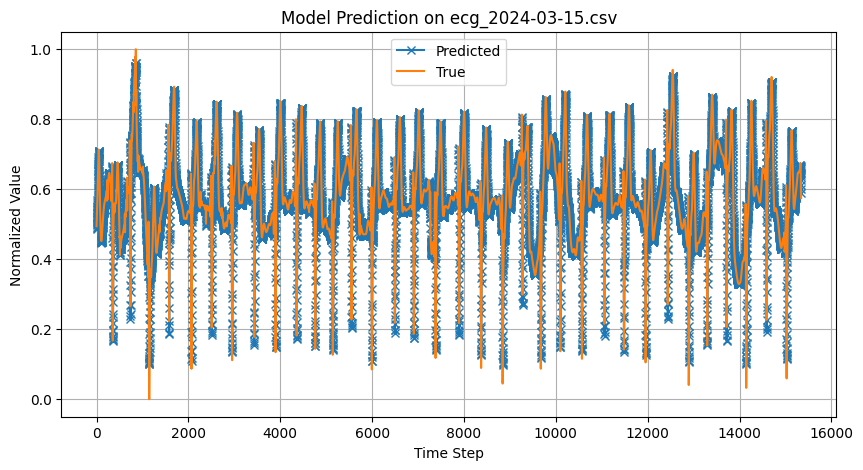

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 데이터도 같은 장치로 옮김
X_tensor = X_tensor.to(device)

# 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor)

# 예측 결과를 다시 CPU로 옮겨 numpy로 변환
y_pred_np = y_pred.cpu().numpy()
y_true_np = y_tensor.cpu().numpy()  # y_tensor도 GPU에 있을 수 있어

# 예측 정확도 출력
mae = mean_absolute_error(y_true_np, y_pred_np)
mse = mean_squared_error(y_true_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_np, y_pred_np)

print(f"예측 정확도 지표:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(y_pred_np, label='Predicted', marker='x')
plt.plot(y_true_np, label='True')
plt.legend()
plt.title(f"Model Prediction on {filename}")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.grid()
plt.show()
